# Hurricanes: Wind and Sea Surface Temperature
## Overview

This notebook demonstrates how to access two cloud-hosted Earthdata granules using the [Commmon Metadata Repository (CMR) API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html). The granules are from two different DAACs ([GES DISC](https://disc.gsfc.nasa.gov) and [PO.DAAC](https://podaac.jpl.nasa.gov/)). It shows the process of obtaining and plotting two variables from two distinct granules hosted in [S3 buckets](https://disc.gsfc.nasa.gov/information/glossary?keywords=s3&title=S3%20Bucket): sea surface temperature (SST) from the [GHRSST Level 4 MUR Global Foundation Sea Surface Temperature Analysis (v4.1) (GHRSST)](https://podaac.jpl.nasa.gov/dataset/MUR-JPL-L4-GLOB-v4.1?ids=&values=&provider=POCLOUD#)) and calculated 2-meter (2M) wind velocity from the [MERRA-2 hourly time-averaged reanalysis dataset (M2T1NXSLV.5.12.4)](https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary?keywords=M2T1NXSLV.5.12.4), before plotting them together on 25 October 2012 over the Caribbean Sea when Hurricane Sandy was at peak strength. 

## Learning Objectives
- Search for data programmatically using known parameters 
- Access data within the AWS cloud using the `earthaccess` python library
- Access data archived by 2 NASA data centers from the AWS cloud
- Visualize wind speed and sea surface temperature together during a hurricane event

## Requirements
### 1. Compute environment - This notebook can **only** be run in an **AWS Cloud instance running in the `us-west-2` region**.
### 2. Earthdata Login
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

### Install Packages

In [1]:
import earthaccess
import xarray as xr
import requests
import s3fs
import numpy as np
import pprint
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import boto3
from IPython.display import display, Markdown

%matplotlib inline

We recommend authenticating your Earthdata Login (EDL) information using the `earthaccess` python package as follows:

In [2]:
auth = earthaccess.login(strategy="netrc") # works if the EDL login already been persisted to a netrc
if not auth.authenticated:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)

You're now authenticated with NASA Earthdata Login
earthaccess generated a token for CMR with expiration on: 10/29/2023
earthaccess generated a token for CMR with expiration on: 10/29/2023
Using .netrc file for EDL


### Retrieve Granule S3 Links

To retrieve the S3 URLs, we will use the [CMR Search API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html) to pass the “[Short Name](https://wiki.earthdata.nasa.gov/display/CMR/Short+Name)” of the dataset, the version of the dataset, the temporal range, and the page size for the JSON response. For GES DISC datasets, you can find the short name and version by navigating to any dataset landing page, where it will be listed in the “Product Summary” tab. We will also retrieve the S3 token endpoints, used for accessing the S3 buckets with our Earthdata credentials:

In [3]:
cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules'

merra_response = requests.get(cmr_url, 
                                params={
                                    'short_name': 'M2T1NXSLV',
                                    'version': '5.12.4',
                                    'temporal': '2012-10-25T00:00:00Z',
                                    'page_size': 1,
                                    },
                                headers={
                                    'Accept': 'application/json'
                                    }
                               )

# Parse S3 Token Endpoint and S3 URL

print('S3 Token Endpoint:')

for element in merra_response.json()['feed']['entry'][0]['links']:
    if element['href'].endswith('s3credentials'):
        print(element['href'])
        gesdisc_s3 = element['href']
        
print('S3 URL:')

for element in merra_response.json()['feed']['entry'][0]['links']:
    if element['rel'] == 'http://esipfed.org/ns/fedsearch/1.1/s3#':
        print(element['href'])
        merra_fn = element['href']

S3 Token Endpoint:
https://data.gesdisc.earthdata.nasa.gov/s3credentials
S3 URL:
s3://gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2012/10/MERRA2_400.tavg1_2d_slv_Nx.20121025.nc4


Then, we build a similar request for retrieving our sea surface temperature data from the GHRSST dataset at 2012-10-25 00Z. The short name and version for this dataset was retrieved from its PO.DAAC dataset landing page, under the “Information” tab.

In [4]:
ghrsst_response = requests.get(cmr_url, 
                                params={
                                    'short_name': 'MUR-JPL-L4-GLOB-v4.1',
                                    'version': '4.1',
                                    'temporal': '2012-10-25T00:00:00Z',
                                    'page_size': 1,
                                    },
                                headers={
                                    'Accept': 'application/json'
                                    }
                               )

# Parse S3 Token Endpoint and S3 URL

print('S3 Token Endpoint:')

for element in ghrsst_response.json()['feed']['entry'][0]['links']:
    if element['href'].endswith('s3credentials'):
        print(element['href'])
        podaac_s3 = element['href']
        
print('S3 URL:')

for element in ghrsst_response.json()['feed']['entry'][0]['links']:
    if element['rel'] == 'http://esipfed.org/ns/fedsearch/1.1/s3#':
        print(element['href'])
        ghrsst_fn = element['href']

S3 Token Endpoint:
https://archive.podaac.earthdata.nasa.gov/s3credentials
S3 URL:
s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20121025090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc


### Obtain S3 Credentials and Open Bucket Granules

Direct S3 access is granted to the user through a temporary token, which **will last for one hour, and will need to be rerun after that hour has passed to access the bucket**. Then, to access the bucket, we can pass this token into the S3FS <code>S3FileSystem()</code> function which will "mount" the S3 bucket to our notebook as if it were a locally stored file system. Here, we create a function that queries the S3 Token Endpoint with their Earthdata credentials, stored in a netrc file, using the Python <code>requests</code> library. Next, it returns an <code>s3fs.core.S3FileSystem</code> object that represents the "mounted" S3 bucket: 

In [5]:
# Define a function for S3 access credentials

def begin_s3_direct_access(daac_url):
    
    # Retrieve the token as a JSON
    response = requests.get(daac_url).json()
    
    # Mount the bucket and return it as an S3FileSystem object
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

We need two tokens in order to access the two different buckets, so we will perform two function calls with the two S3 Token Endpoints retrieved from CMR, stored in separate variables. If you immediately receive an error, double-check that your username and password were entered correctly in your netrc file, or that you can access the following URL: https://data.gesdisc.earthdata.nasa.gov

In [6]:
# Open S3 file systems with S3FS

gesdisc_fs = begin_s3_direct_access(gesdisc_s3)
podaac_fs = begin_s3_direct_access(podaac_s3)

# Check that the file system is intact as an S3FileSystem object, which means that token is valid

type(gesdisc_fs)
type(podaac_fs)

s3fs.core.S3FileSystem

### Open Granules in Xarray

In order to open the granules in Xarray, we must use the S3FS <code>open()</code> function. Here, we pass the S3 URLs from each separate file system into two different variables: 

In [7]:
# Open datasets with S3FS

merra_ds = xr.open_dataset(gesdisc_fs.open(merra_fn))
ghrsst_ds = xr.open_dataset(podaac_fs.open(ghrsst_fn))

Now, the granules are stored in memory as Xarray datasets, which will be stored as long as the kernel is running. Here, we clip to the extent over where the hurricane was:

In [8]:
min_lon = -89
min_lat = 14
max_lon = -67
max_lat = 31

merra_ds = merra_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
ghrsst_ds = ghrsst_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

### Convert Dataset Grids

Here, we interpolate the GHRSST grid to the MERRA grid using Xarray's <code>interp()</code> function:

In [9]:
ghrsst_ds = ghrsst_ds.interp(lat=merra_ds.lat, lon=merra_ds.lon)
ghrsst_ds

<xarray.Dataset>
Dimensions:           (time: 1, lat: 35, lon: 35)
Coordinates:
  * time              (time) datetime64[ns] 2012-10-25T09:00:00
  * lat               (lat) float64 14.0 14.5 15.0 15.5 ... 29.5 30.0 30.5 31.0
  * lon               (lon) float64 -88.75 -88.12 -87.5 ... -68.75 -68.12 -67.5
Data variables:
    analysed_sst      (time, lat, lon) float64 nan nan nan ... 300.0 299.4 299.4
    analysis_error    (time, lat, lon) float64 nan nan nan ... 0.37 0.37 0.37
    mask              (time, lat, lon) float64 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0
    sea_ice_fraction  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes: (12/47)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

### Plot Variables using Matplotlib and Cartopy

Finally, we use Matplotlib and Cartopy to plot a color mesh and quiver plot of SSTs and 2M winds of Hurricane Sandy at her peak strength:

Text(0.5, 0.95, 'GHRSST Analyzed SST and MERRA-2 2M Wind Vectors on 2012-10-25T00:00:00Z')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


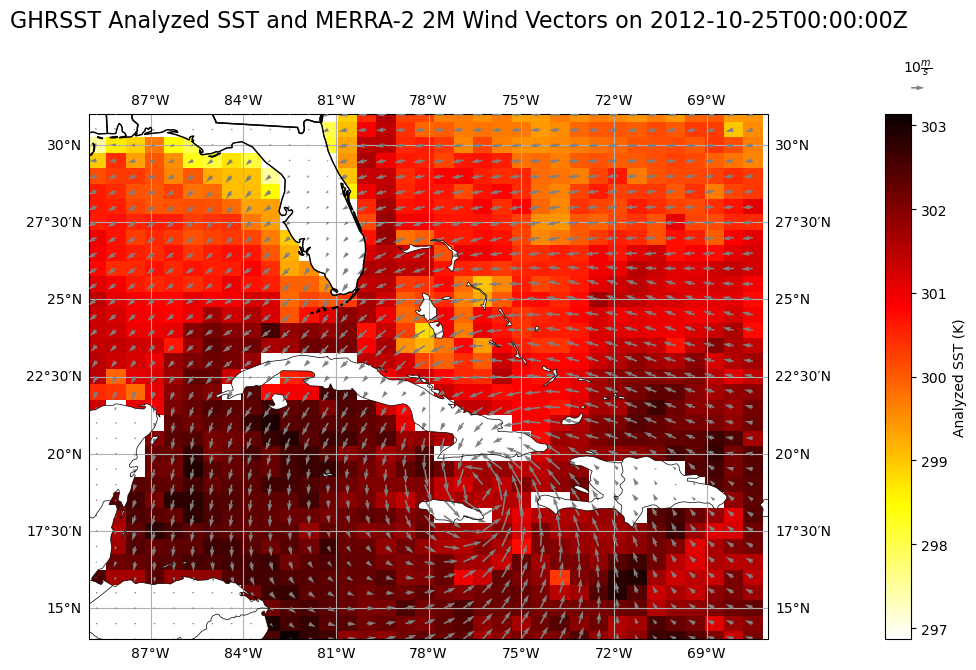

In [10]:
# Pre-configure wind vector variables

u=merra_ds.U2M
v=merra_ds.V2M
lon=merra_ds.lon
lat=merra_ds.lat

lons, lats = np.meshgrid(lon, lat)

# Plotting routines:

# Figure size
plt.rcParams['figure.figsize'] = 15, 15

# Figure and geography setup
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-89, -67, 14, 31], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5, zorder=5) 
ax.add_feature(cfeature.LAND, facecolor='white', zorder=2) 
ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=5)
ax.add_feature(cfeature.STATES, zorder=5)

# Colormesh of SSTs
mmp = ax.pcolormesh(lons, lats, ghrsst_ds.analysed_sst.isel(time=0), 
              cmap='hot_r', transform=ccrs.PlateCarree(), zorder=1)

# Quiver plot of 2M vector field
q = ax.quiver(lons, lats, u.isel(time=0).values, v.isel(time=0).values, zorder=4, 
              transform=ccrs.PlateCarree(), scale_units='inches', color='gray')

# Quiver key for scale
ax.quiverkey(q, 1.22, 1.05, 10, r'$10 \frac{m}{s}$', zorder=4)

# Lat/lon grid lines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# SST color bar setup
cbar = plt.colorbar(mmp, pad=0.1)
cbar.set_label("Analyzed SST (K)")

# Figure title
fig.suptitle("GHRSST Analyzed SST and MERRA-2 2M Wind Vectors on 2012-10-25T00:00:00Z", size=16, y=0.95)